<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import statsmodels.api as sm
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import collections
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


2.2.0-rc4


# **Exploration**

In [2]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


In [3]:
series = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "values"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)
series.head()

,values
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


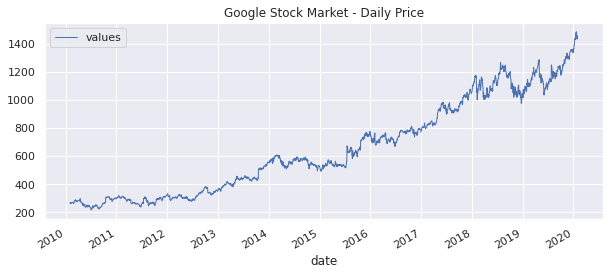

In [4]:
sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
series.plot(title='Google Stock Market - Daily Price')

# **Preparation**

In [0]:
# Set seed for reproducibility
tf.random.set_seed(7)

**Data Normalization**

In [87]:
# LSTMs are sensitive to scale of input data
dataset = series.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[-0.92391232],
       [-0.92540345],
       [-0.91779077],
       ...,
       [ 0.91689178],
       [ 0.94629088],
       [ 0.95585415]])

**Train & Test Split**

In [88]:
# in % of complete dataset
split = 0.8
train_size = int(len(dataset) * split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train [0:5] # Show first few values in train data array

array([[-0.92391232],
       [-0.92540345],
       [-0.91779077],
       [-0.92880954],
       [-0.92527003]])

**Create Sliding Windows (X input & Y output)**

* Window is the number of previous time steps to use as input variables to predict the next time period
* Given the current time (t) we want to predict the value at the next time in the sequence (t+1), 
* Phrased as a regression: input variables are t-2, t-1, t and the output variable is t+1

In [0]:
window = 3 # Use (t), (t-1) and (t-2) as input variables X
features = 1 # Use only one time series (Google stock data)

# Convert an array of values into a dataset matrix
def create_dataset(dataset, window=window):
	dataX, dataY = [], []
	for i in range(len(dataset)-window-1):
		a = dataset[i:(i+window), 0]
		dataX.append(a)
		dataY.append(dataset[i + window, 0])
	return np.array(dataX), np.array(dataY)

# X is input data = value (at t, and t-1, t-2, depending on window size)
# Y is target data = value at t+1
# Each is additionally divided into train and test set

# Reshape into X=t and Y=t+1 and get as arrays
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

In [61]:
# X input has 3 (= window size) values at each step
trainX

array([[-0.92391232, -0.92540345, -0.91779077],
       [-0.92540345, -0.91779077, -0.92880954],
       [-0.91779077, -0.92880954, -0.92527003],
       ...,
       [ 0.43776308,  0.44992598,  0.47875792],
       [ 0.44992598,  0.47875792,  0.50106702],
       [ 0.47875792,  0.50106702,  0.49203937]])

In [10]:
# Y output has here only one value (t+1) at each step
trainY

array([-0.92880954, -0.92527003, -0.92355912, ...,  0.50106702,
        0.49203937,  0.50169726])

**Reshape Data for LSTM**

* Data is in shape **[samples, features]**. LSTM expects **[samples, time steps, features]**
* Reminder 2D array: shape (n,m), n [0] = rows (time steps), m [1] = column(s)
* Shape: First Block: t, t+1, t+2. Second: t+1, t+2, t+3. Third: t+2, t+3, t+4.
* Approach 1: Use past observations as separate input features =(trainX.shape[0], features, trainX.shape[1])
* Approach 2: Use past observations as time steps of the one input feature **(we do here!)**

In [90]:
trainX = tf.reshape(trainX, (trainX.shape[0], trainX.shape[1], features))
testX = tf.reshape(testX, (testX.shape[0], testX.shape[1], features))
trainX

<tf.Tensor: shape=(2008, 3, 1), dtype=float64, numpy=
array([[[-0.92391232],
        [-0.92540345],
        [-0.91779077]],

       [[-0.92540345],
        [-0.91779077],
        [-0.92880954]],

       [[-0.91779077],
        [-0.92880954],
        [-0.92527003]],

       ...,

       [[ 0.43776308],
        [ 0.44992598],
        [ 0.47875792]],

       [[ 0.44992598],
        [ 0.47875792],
        [ 0.50106702]],

       [[ 0.47875792],
        [ 0.50106702],
        [ 0.49203937]]])>

# **Model**

**Set Hyperparameter**

In [0]:
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = 'mean_squared_error'
activation = 'tanh'
recurrent_activation= 'sigmoid'
epochs = 8
repeat = 2
batch_size = 4
verbose = 1
units = 16
dropout = 0.02
recurrent_dropout = 0.02

**Create Model** 

In [0]:
# Deep Stacked LSTM with Memory Between Batches
model = tf.keras.Sequential()
model.add(layers.LSTM(units, 
               batch_input_shape=(batch_size, window, 1), 
               activation=activation,
               recurrent_activation=recurrent_activation,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               unroll=True,
               stateful=True, 
               return_sequences=True))
model.add(layers.LSTM(units, 
               batch_input_shape=(batch_size, window, 1), 
               activation=activation,
               recurrent_activation=recurrent_activation,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               unroll=True,
               stateful=True, 
               return_sequences=True))
model.add(layers.LSTM(units, 
               batch_input_shape=(batch_size, window, 1),
               activation=activation,
               recurrent_activation=recurrent_activation,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               unroll=True,
               stateful=True))
model.add(layers.Dense(1))

**Display Model Topology**

In [93]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (4, 3, 16)                1152      
_________________________________________________________________
lstm_19 (LSTM)               (4, 3, 16)                2112      
_________________________________________________________________
lstm_20 (LSTM)               (4, 16)                   2112      
_________________________________________________________________
dense_6 (Dense)              (4, 1)                    17        
Total params: 5,393
Trainable params: 5,393
Non-trainable params: 0
_________________________________________________________________


**Compile Model**

In [0]:
model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])

**Train Model**

In [95]:
for i in range(repeat):
	model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False)
	model.reset_states()

Epoch 1/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0871 - accuracy: 0.0000e+00
Epoch 2/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0151 - accuracy: 0.0000e+00
Epoch 3/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0128 - accuracy: 0.0000e+00
Epoch 4/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0116 - accuracy: 0.0000e+00
Epoch 5/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0118 - accuracy: 0.0000e+00
Epoch 6/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0113 - accuracy: 0.0000e+00
Epoch 7/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0112 - accuracy: 0.0000e+00
Epoch 8/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0106 - accuracy: 0.0000e+00
Epoch 1/8
502/502 [==============================] - 2s 3ms/step - loss: 0.0070 - accuracy: 0.0000e+00
Epoch 2/8
502/502 [==============================] - 2s 3ms/step - loss: 

In [0]:
# Second (simpler) Model
# Use past observations as input features (=3) and only one time step

# Reshape Data Format for LSTM
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Model create and train
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, window)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# **Predictions**

**Make Predictions**

In [0]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

**Invert predictions**

In [0]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

**Calculate RMSE**

In [98]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 89.73 RMSE
Test Score: 104.48 RMSE


**Plot results**

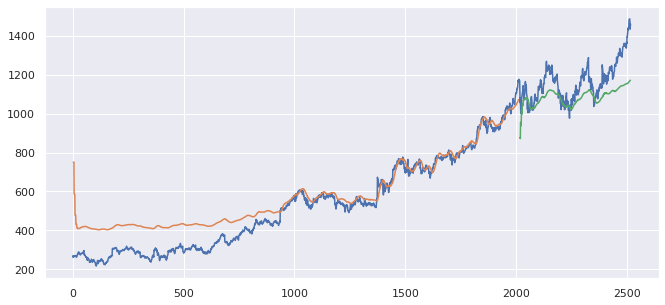

In [99]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
sns.set(rc={'figure.figsize':(11, 5)})
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Model got pretty good on adapting to both test and train data. But keep in mind the model only predicts next day, and may not be able to learn structural market changes etc. This is just a demo for learning model building, not applicable to real world at this configuration.

# **Residuals**

Residuals are useful in checking whether a model has adequately captured the information in the data. In a good model the residuals are stationary, which can be broken down into following requirements:

**Essential (necessary) properties:**

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

**Additional useful (but not necessary) properties:**

3. The residuals have constant variance.
4. The residuals are normally distributed.


**Get residuals**

In [100]:
residuals = (testY[0] - testPredict[:,0])
res = pd.DataFrame(data=residuals, columns=['residuals'])
res.head()

,residuals
0,291.675781
1,236.394958
2,180.818421
3,208.663697
4,93.473999


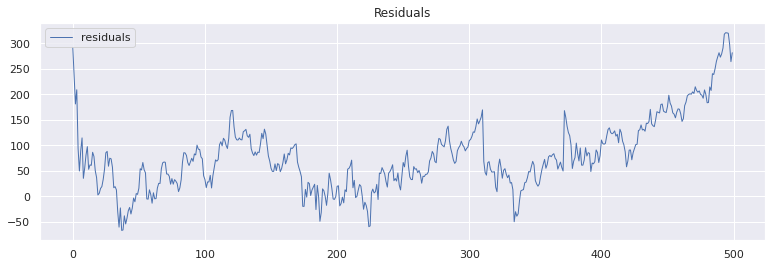

In [101]:
# Visualize Series
sns.set(rc={'figure.figsize':(13, 4), "lines.linewidth": 1.0})
res.plot(title='Residuals')

In [102]:
res.describe()

,residuals
count,500.000000
mean,78.268281
std,69.281620
min,-67.117309
25%,32.555725
50%,67.858216
75%,111.039124
max,320.476196


**Are residuals autocorrelated?**

In [25]:
# Durban-Watson Statistic. Value 2: no serial correlation. 0: positive correlation. 4: negative correlation
statsmodels.stats.stattools.durbin_watson(res.residuals, axis=0)

0.03140923941634127

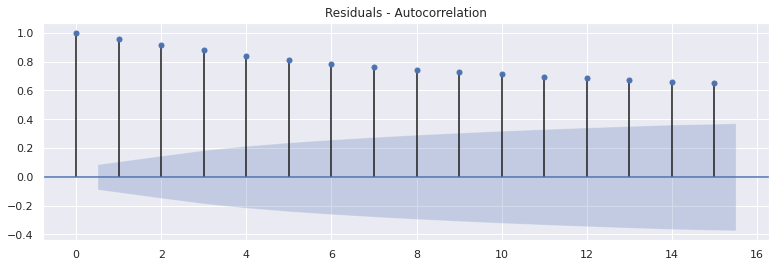

In [26]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(res.residuals.squeeze(), lags=15)
plt.title('Residuals - Autocorrelation')
plt.show()

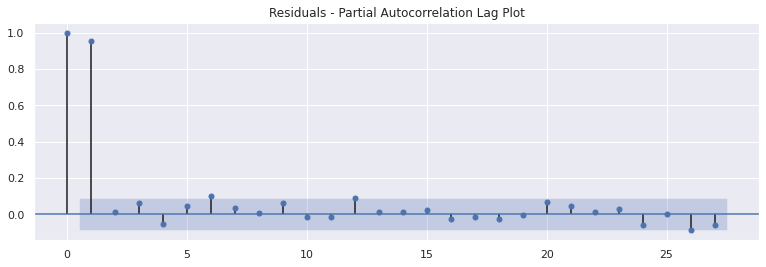

In [27]:
plot_pacf(res.residuals)
plt.title('Residuals - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


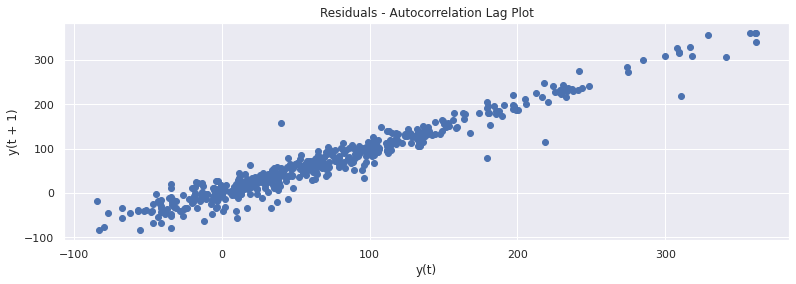

In [28]:
lag_plot(res.residuals)
plt.title('Residuals - Autocorrelation Lag Plot')
plt.show()

Yes, there is a strong autocorrelation at lag 1. This is typical for financial time series, as they are similar to Markov processes.

**Is the mean zero?**

In [29]:
# Mean (must be nearly zero)
res.residuals.mean()

73.19660499116414

Text(0.5, 1.0, 'Residuals - Boxplot')

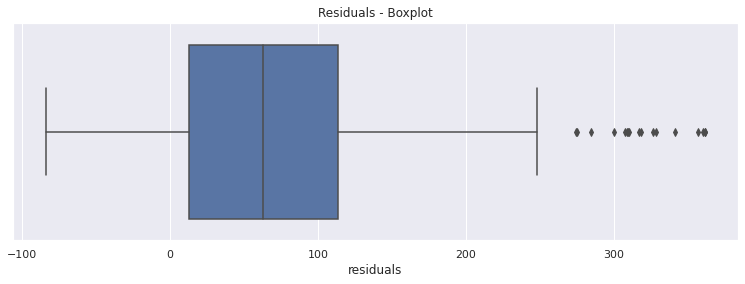

In [30]:
sns.boxplot(res.residuals).set_title('Residuals - Boxplot')

No, residuals don't have the mean at zero.

**Are residuals normally distributed?**

In [104]:
# Distribution (H0: sample normal distributed)
scipy.stats.normaltest(res.residuals)

NormaltestResult(statistic=66.07407947133014, pvalue=4.489478999366322e-15)

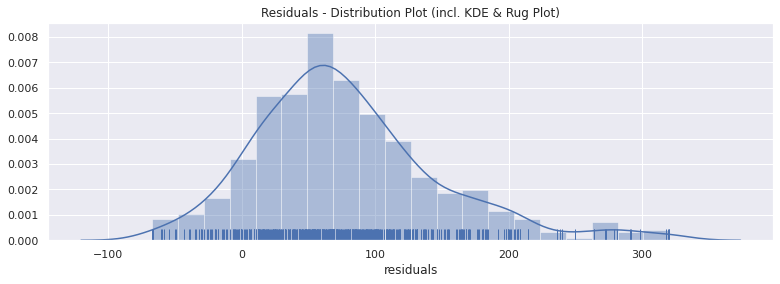

In [103]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((res.residuals), hist=True, rug=True).set_title('Residuals - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

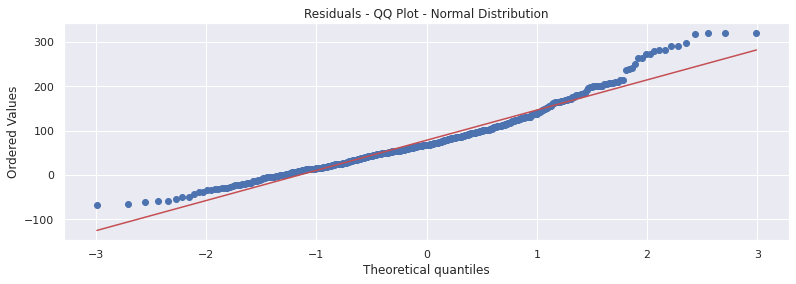

In [105]:
stats.probplot(res.residuals, dist="norm", plot=plt)
plt.title('Residuals - QQ Plot - Normal Distribution')
plt.show()

No, residuals are not normally distributed. Though it seems normally distributed without the outliers.

**Is the variance constant? (Stationarity)**

In [106]:
# Augmented Dickey Fuller. H0: There is a unit root for the series (non stationary)
statsmodels.tsa.stattools.adfuller(res.residuals, maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False)


(-5.67496933233821,
 5.8180026178018604e-05,
 0,
 499,
 {'1%': -4.394499384993899,
  '10%': -3.56061563621329,
  '5%': -3.844276182553822},
 4159.653923677941)

P-value is < 0.05. reject H0. Series is stationary.